In [121]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression

In [124]:
target = "Inflation Rate (%)"
chart_target="inflation"
filename = "../../data/raw/economic_indicators_dataset_2010_2023.csv"
file_tag = "Aggregation"

data: DataFrame = read_csv(filename, na_values="")
data["Date"] = to_datetime(data["Date"])
data = data.set_index("Date").sort_index()

usa_data = data[data["Country"] == "USA"]
usa_data = usa_data.groupby(level=0).mean(numeric_only=True)

series: Series = usa_data[target]
train, test = series_train_test_split(series, 0.80)

**Multivariate Data**

In [125]:
multi_cols = [
    "Inflation Rate (%)",
    "GDP Growth Rate (%)",
    "Unemployment Rate (%)",
    "Interest Rate (%)",
    "Stock Index Value",
]
multi_df: DataFrame = usa_data[multi_cols].copy()

train_multi, test_multi = series_train_test_split(multi_df, 0.80)

train_multi = train_multi.loc[train.index]
test_multi = test_multi.loc[test.index]

**MVI Analysis** - there are no missing values in the train or test set, verified below:

In [126]:
train.isna().sum(), test.isna().sum()
#train_multi.isna().sum()

(np.int64(0), np.int64(0))

**Aggregation**

Date
2010-01-01    5.837500
2011-01-01    2.756667
2012-01-01    6.375000
2013-01-01    9.630000
2014-01-01    4.631111
Freq: YS-JAN, Name: Inflation Rate (%), dtype: float64
            Inflation Rate (%)  GDP Growth Rate (%)  Unemployment Rate (%)  \
Date                                                                         
2010-01-01            5.837500             2.262500               5.150000   
2011-01-01            2.756667             1.893333               9.493333   
2012-01-01            6.375000            -2.346250               5.452500   
2013-01-01            9.630000            -0.040000               8.580000   
2014-01-01            4.631111             0.211111               6.261111   

            Interest Rate (%)  Stock Index Value  
Date                                              
2010-01-01           4.322500        7984.770000  
2011-01-01           3.883333       31602.616667  
2012-01-01           6.848750       17130.092500  
2013-01-01           6.

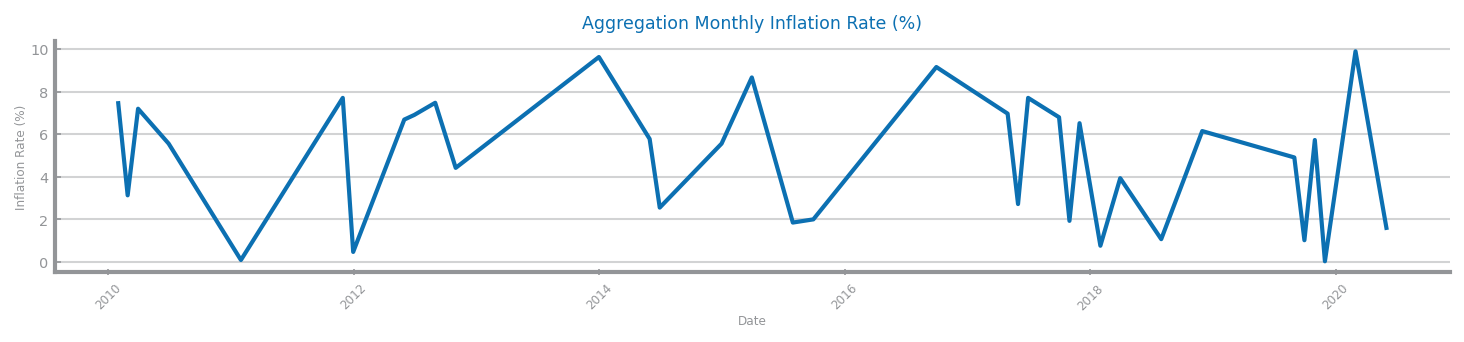

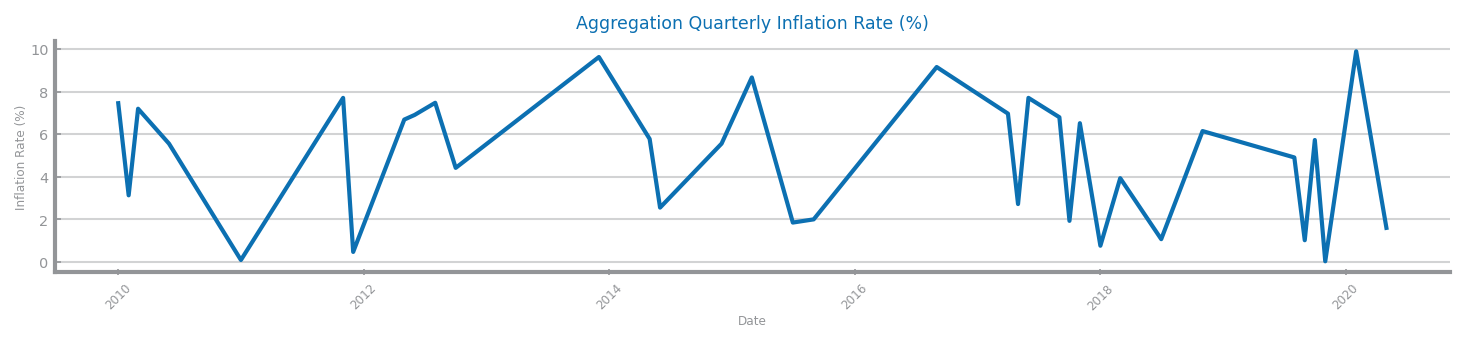

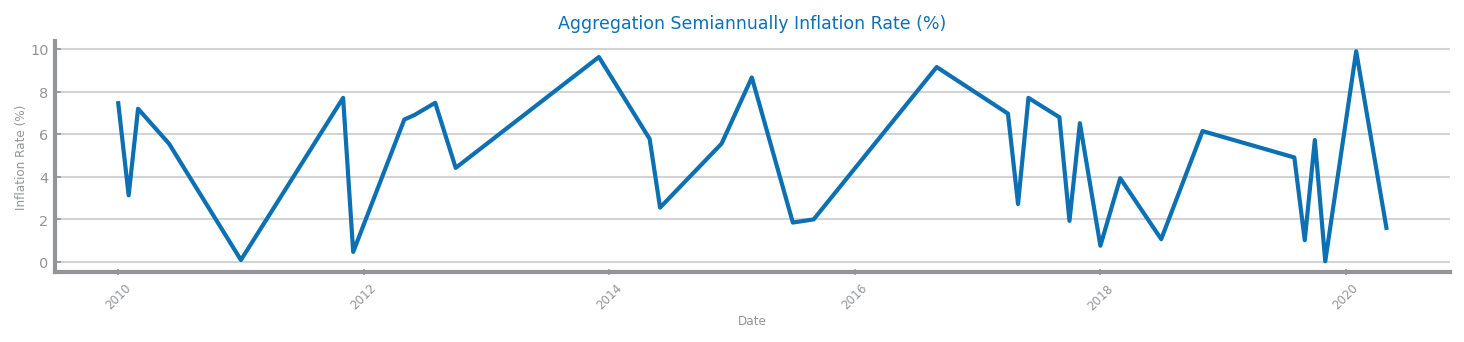

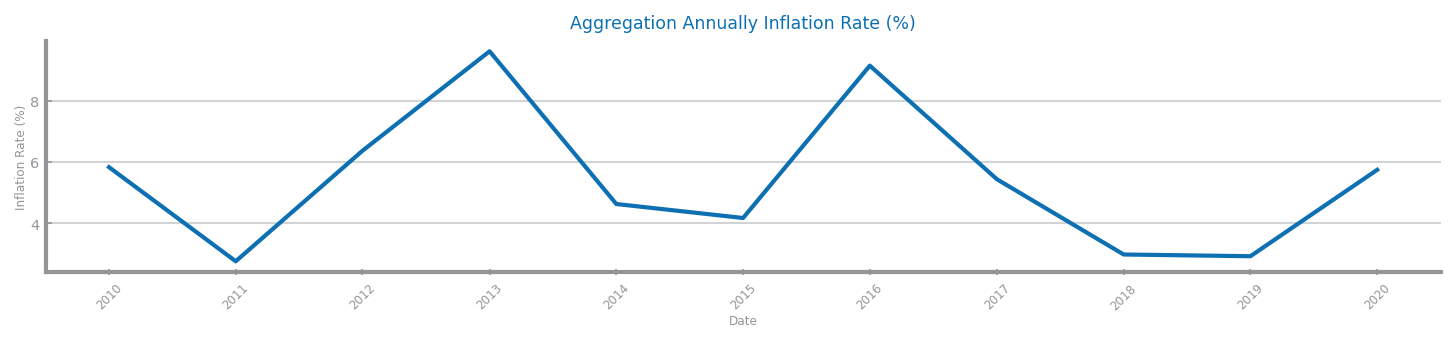

In [129]:
# trying aggregates of 3, 6, and 12 months

series_3M_train: Series = ts_aggregation_by(train, gran_level="3M", agg_func=mean)
series_3M_test: Series = ts_aggregation_by(test, gran_level="3M", agg_func=mean)
series_6M_train: Series = ts_aggregation_by(train, gran_level="6M", agg_func=mean)
series_6M_test: Series = ts_aggregation_by(test, gran_level="6M", agg_func=mean)
series_A_train: Series = ts_aggregation_by(train, gran_level="A", agg_func=mean)
series_A_test: Series = ts_aggregation_by(test, gran_level="A", agg_func=mean)

train_multi_A: DataFrame = ts_aggregation_by(train_multi, gran_level="A", agg_func=mean)
test_multi_A: DataFrame = ts_aggregation_by(test_multi, gran_level="A", agg_func=mean)
print(series_A_train.head())
print(train_multi_A.head())

# plotting the training sets for each


figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} Monthly {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_3M_train.index.to_list(),
    series_3M_train.to_list(),
    xlabel=series_3M_train.index.name,
    ylabel=target,
    title=f"{file_tag} Quarterly {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_6M_train.index.to_list(),
    series_6M_train.to_list(),
    xlabel=series_6M_train.index.name,
    ylabel=target,
    title=f"{file_tag} Semiannually {target}",
)
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_A_train.index.to_list(),
    series_A_train.to_list(),
    xlabel=series_A_train.index.name,
    ylabel=target,
    title=f"{file_tag} Annually {target}",
)
show()


**Evaluation**

**Persistent Optimist**

<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

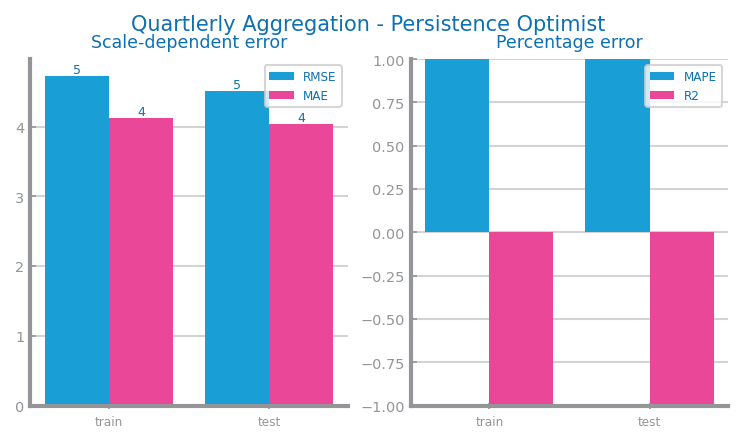

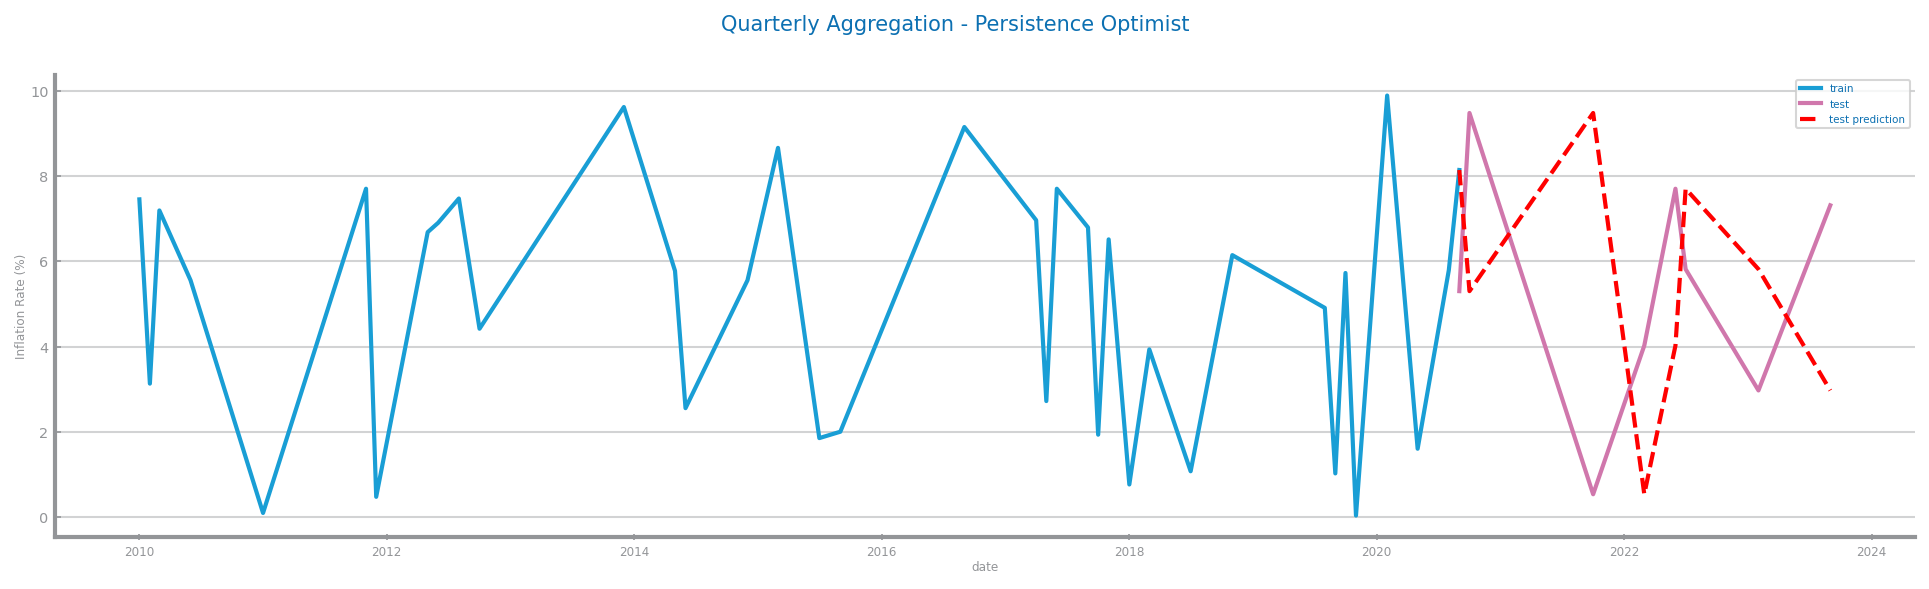

In [92]:
timecol="date"
fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(series_3M_train)
prd_trn_3M: Series = fr_mod.predict(series_3M_train)
prd_tst_3M: Series = fr_mod.predict(series_3M_test)

plot_forecasting_eval(series_3M_train, series_3M_test, prd_trn_3M, prd_tst_3M, title=f"Quartlerly {file_tag} - Persistence Optimist")
#savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_optim_3M_eval.png")

plot_forecasting_series(
    series_3M_train,
    series_3M_test,
    prd_tst_3M,
    title=f"Quarterly {file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_optim_3M_forecast.png")



<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

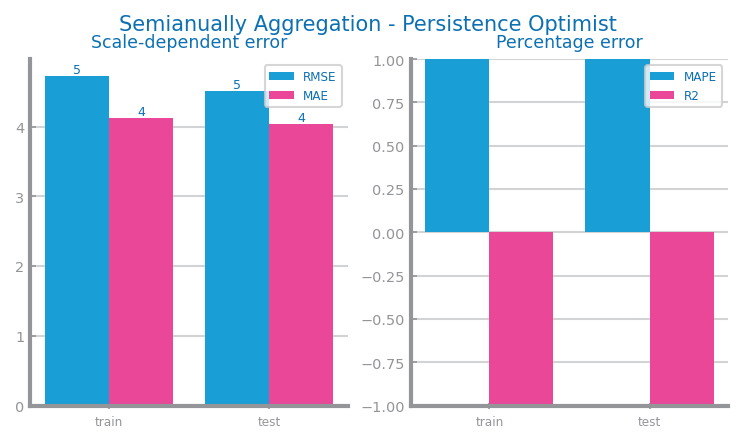

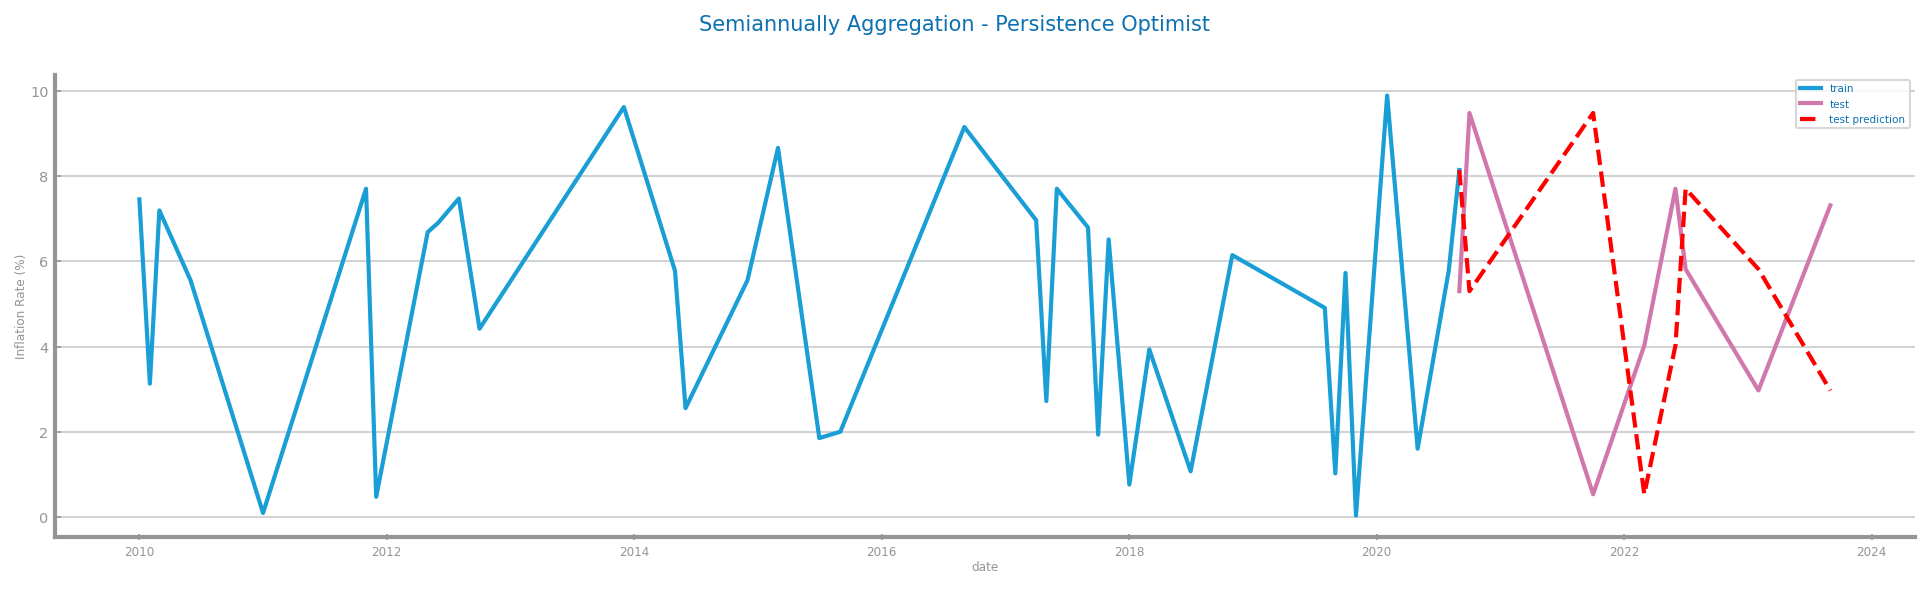

In [93]:
fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(series_6M_train)
prd_trn_6M: Series = fr_mod.predict(series_6M_train)
prd_tst_6M: Series = fr_mod.predict(series_6M_test)

plot_forecasting_eval(series_6M_train, series_6M_test, prd_trn_6M, prd_tst_6M, title=f"Semianually {file_tag} - Persistence Optimist")
#savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_optim_6M_eval.png")

plot_forecasting_series(
    series_6M_train,
    series_6M_test,
    prd_tst_6M,
    title=f"Semiannually {file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_optim_6M_forecast.png")


<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

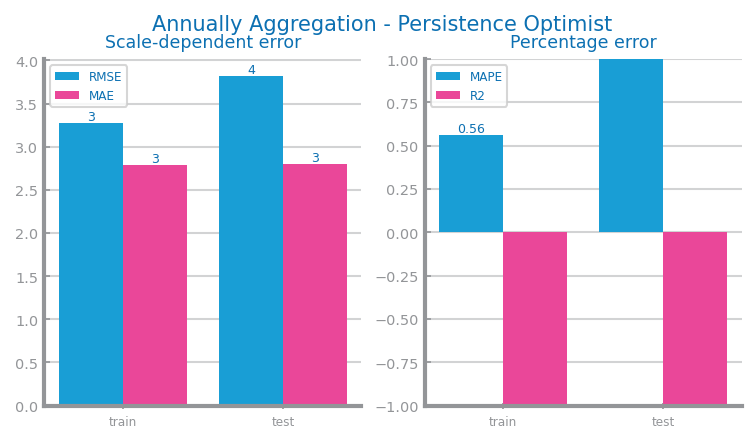

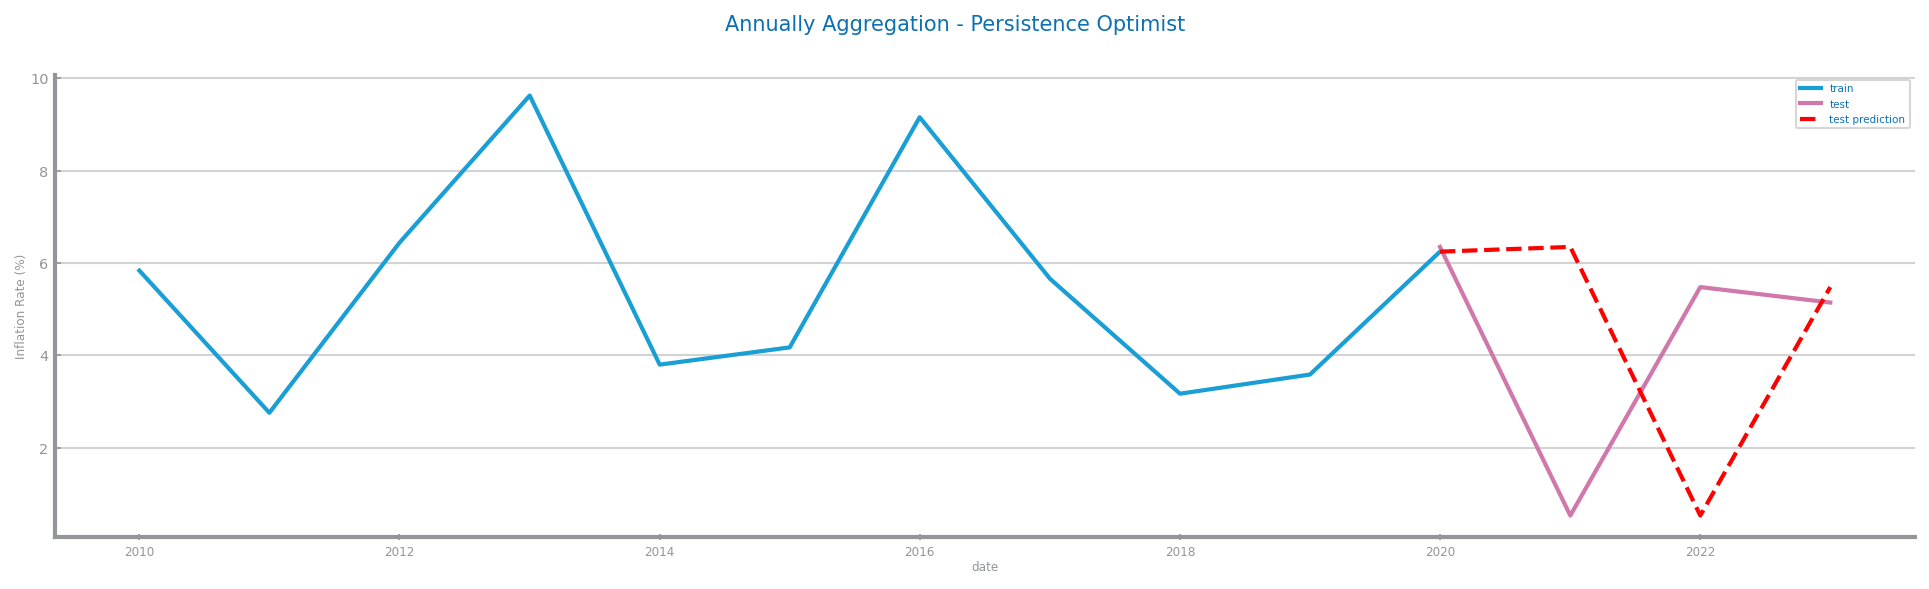

In [94]:
fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(series_A_train)
prd_trn_A: Series = fr_mod.predict(series_A_train)
prd_tst_A: Series = fr_mod.predict(series_A_test)

plot_forecasting_eval(series_A_train, series_A_test, prd_trn_A, prd_tst_A, title=f"Annually {file_tag} - Persistence Optimist")
#savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_optim_A_eval.png")

plot_forecasting_series(
    series_A_train,
    series_A_test,
    prd_tst_A,
    title=f"Annually {file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_optim_A_forecast.png")


**Persistent Realist**

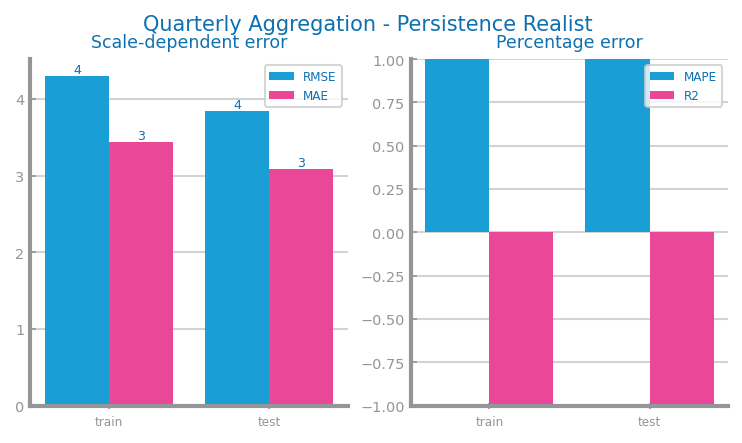

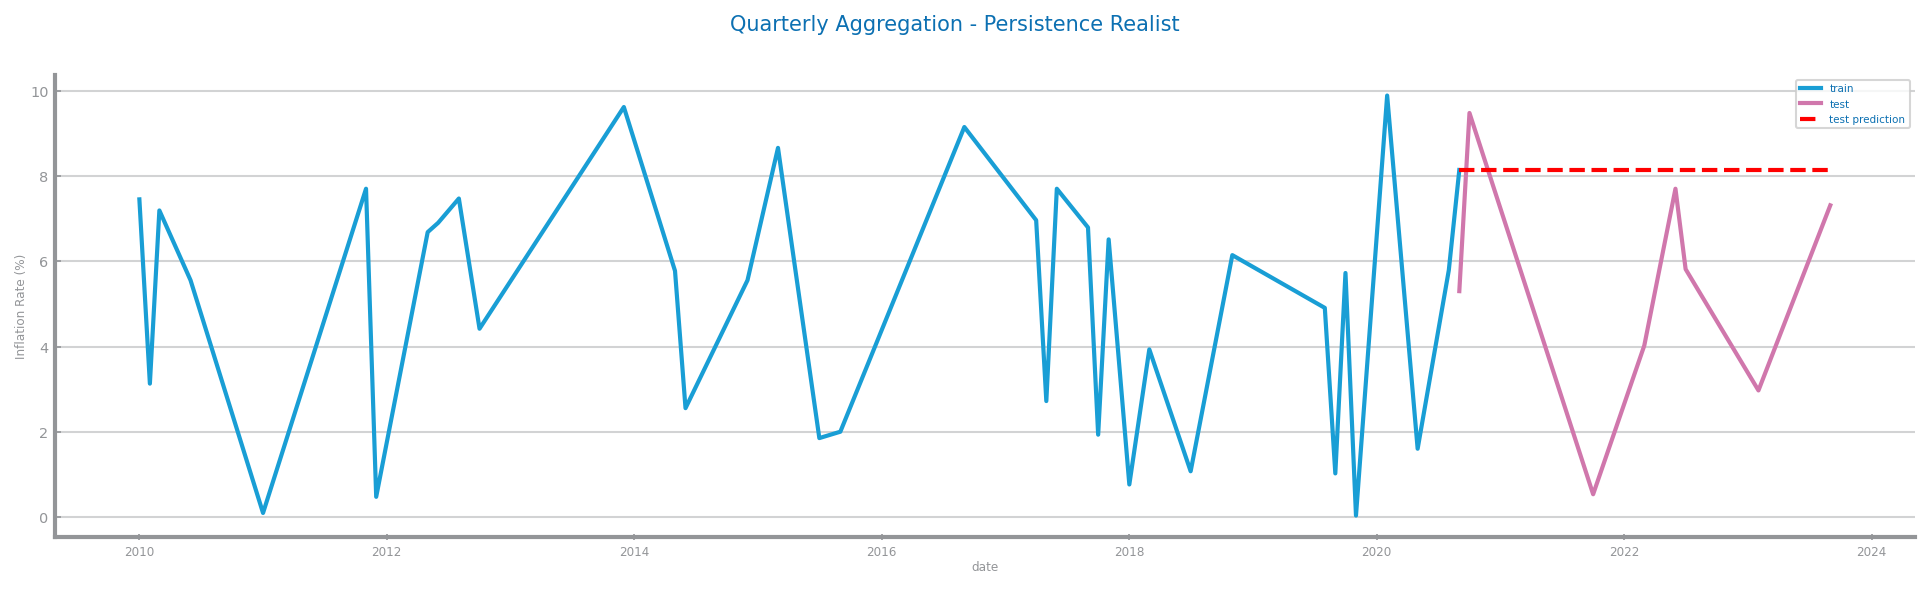

In [95]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_3M_train)
prd_trn_3M: Series = fr_mod.predict(series_3M_train)
prd_tst_3M: Series = fr_mod.predict(series_3M_test)

plot_forecasting_eval(series_3M_train, series_3M_test, prd_trn_3M, prd_tst_3M, title=f"Quarterly {file_tag} - Persistence Realist")
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_real_3M_eval.png")

plot_forecasting_series(
    series_3M_train,
    series_3M_test,
    prd_tst_3M,
    title=f"Quarterly {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_real_3M_forecast.png")


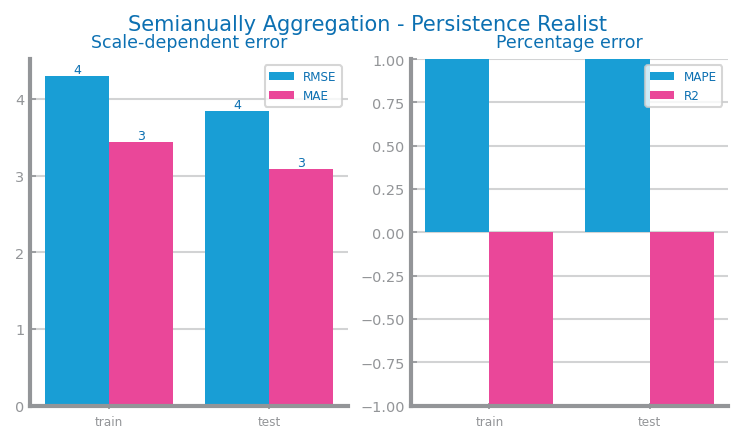

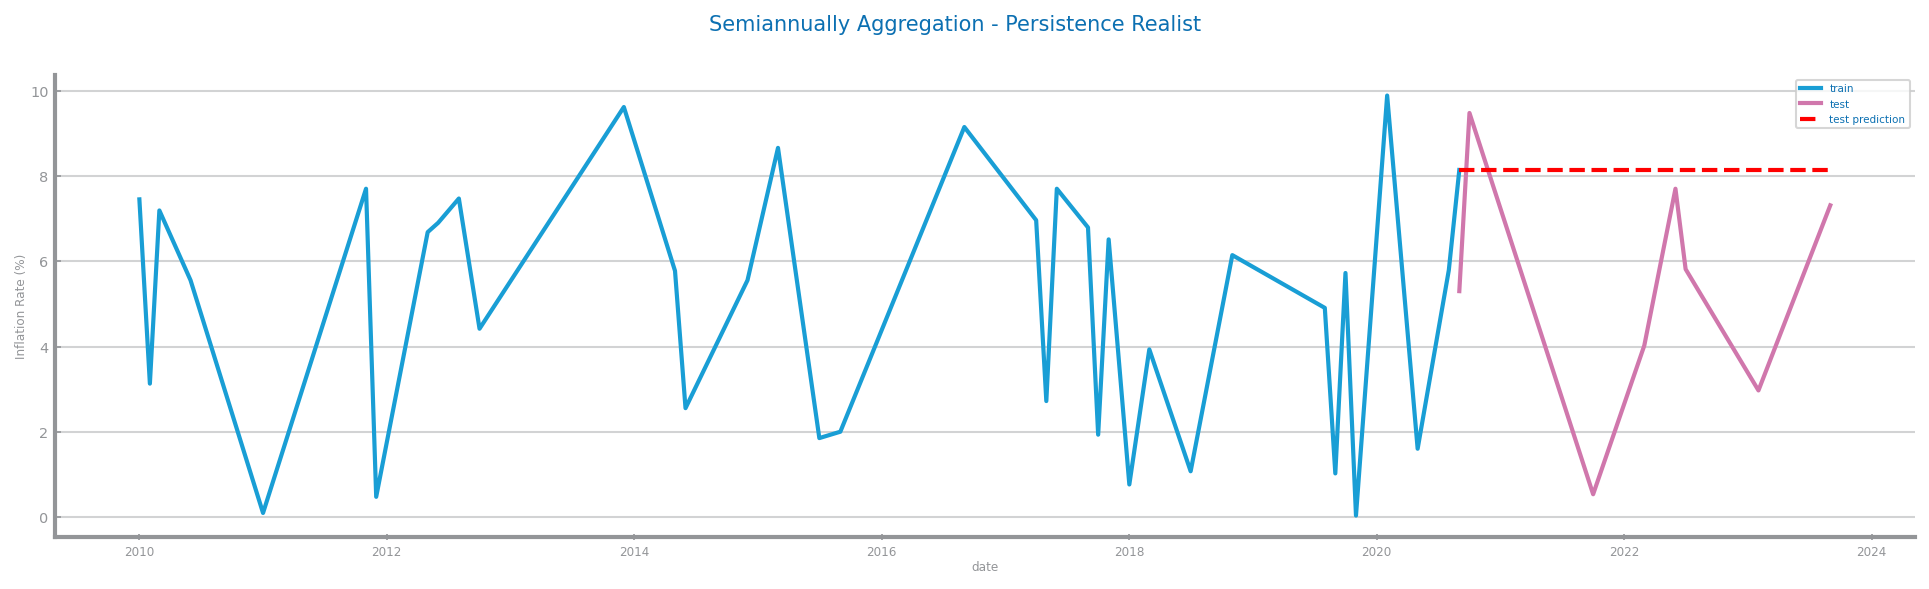

In [96]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_6M_train)
prd_trn_6M: Series = fr_mod.predict(series_6M_train)
prd_tst_6M: Series = fr_mod.predict(series_6M_test)

plot_forecasting_eval(series_6M_train, series_6M_test, prd_trn_6M, prd_tst_6M, title=f"Semianually {file_tag} - Persistence Realist")
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_real_6M_eval.png")

plot_forecasting_series(
    series_6M_train,
    series_6M_test,
    prd_tst_6M,
    title=f"Semiannually {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_real_6M_forecast.png")


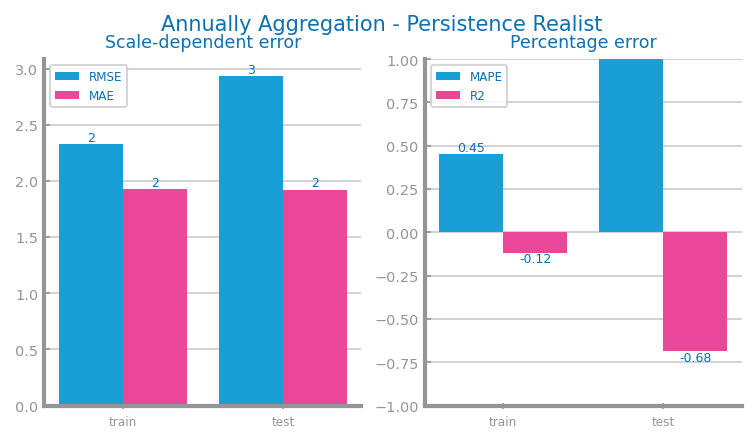

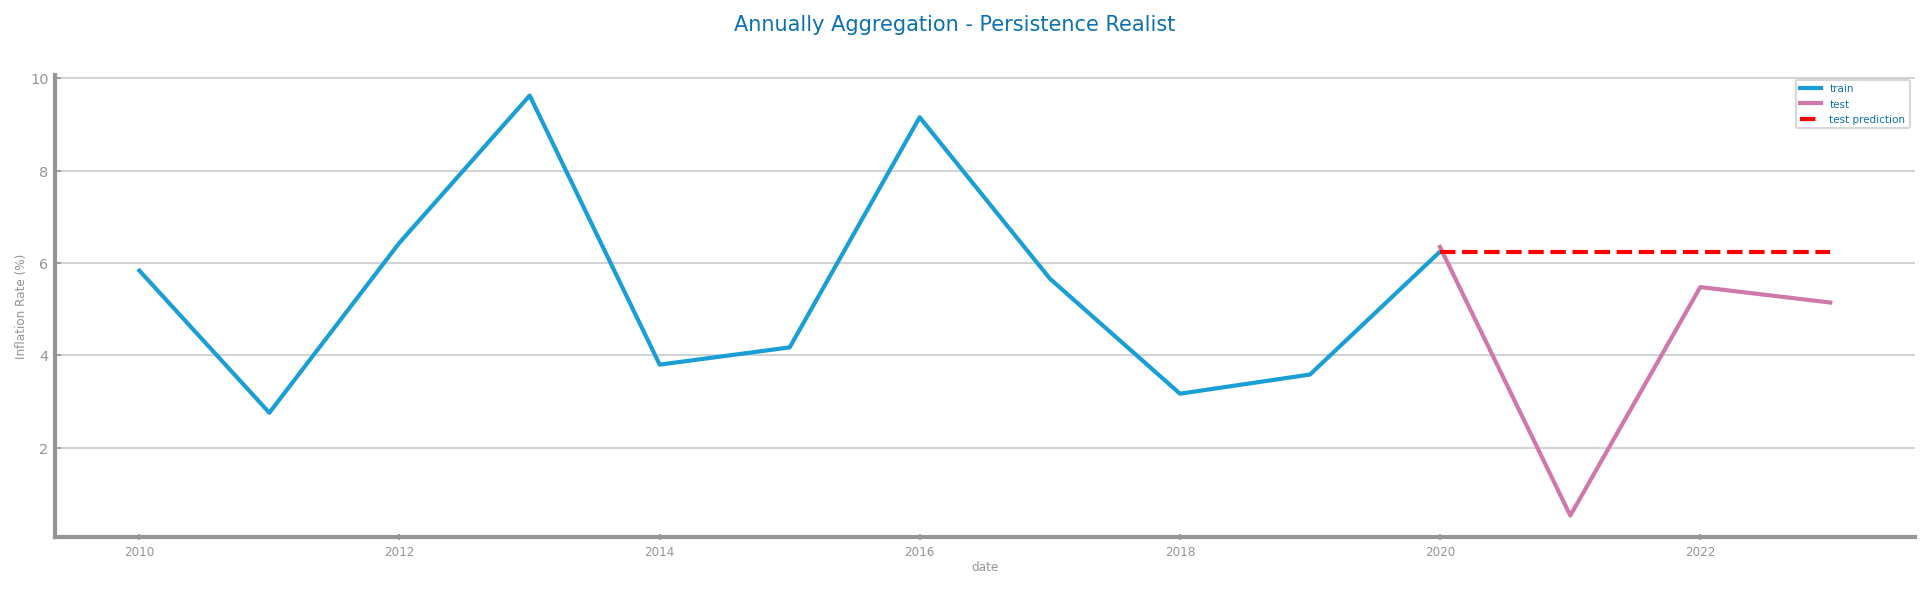

In [97]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(series_A_train)
prd_trn_A: Series = fr_mod.predict(series_A_train)
prd_tst_A: Series = fr_mod.predict(series_A_test)

plot_forecasting_eval(series_A_train, series_A_test, prd_trn_A, prd_tst_A, title=f"Annually {file_tag} - Persistence Realist")
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_real_A_eval.png")

plot_forecasting_series(
    series_A_train,
    series_A_test,
    prd_tst_A,
    title=f"Annually {file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_persistence_real_A_forecast.png")

**Linear Regression**

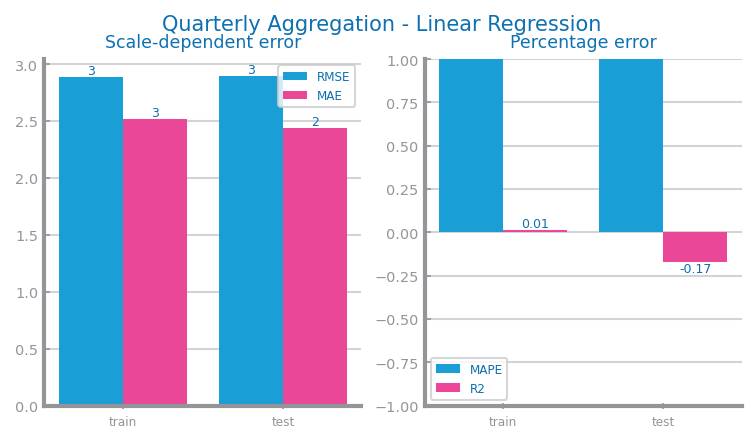

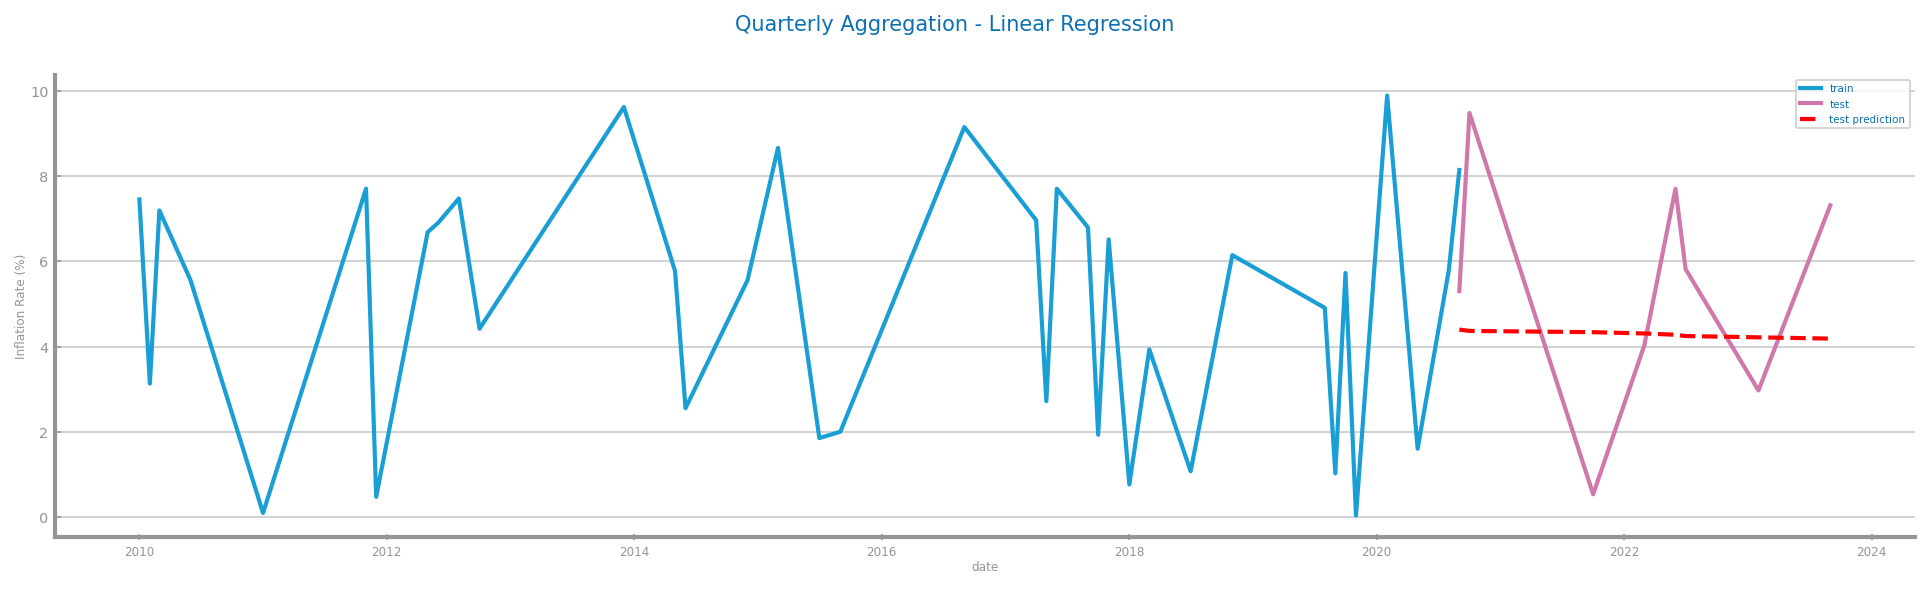

In [98]:
n_trn = len(series_3M_train)
n_tst = len(series_3M_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_3M_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_3M_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_3M: Series = Series(model.predict(trnX), index=series_3M_train.index)
prd_tst_3M: Series = Series(model.predict(tstX), index=series_3M_test.index)

plot_forecasting_eval(
    series_3M_train,
    series_3M_test,
    prd_trn_3M,
    prd_tst_3M,
    title=f"Quarterly {file_tag} - Linear Regression"
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_linear_regression_3M_eval.png")

plot_forecasting_series(
    series_3M_train,
    series_3M_test,
    prd_tst_3M,
    title=f"Quarterly {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_linear_regression_3M_forecast.png")

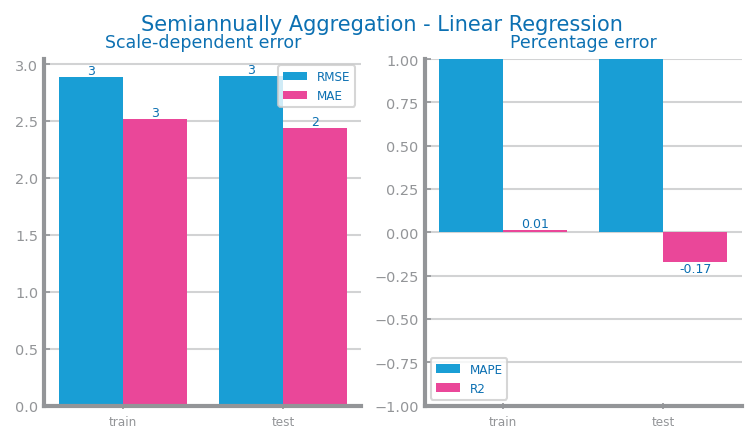

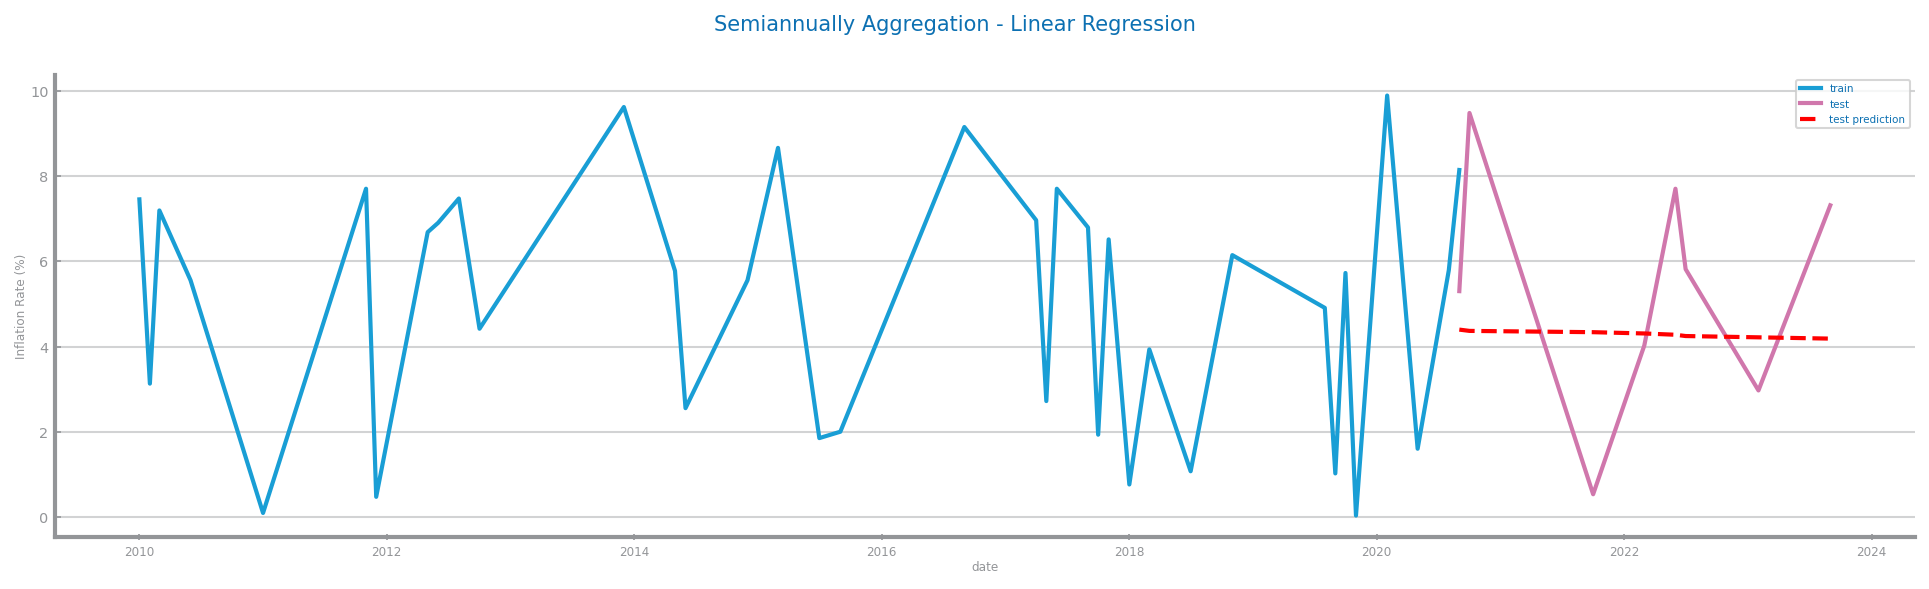

In [99]:
n_trn = len(series_6M_train)
n_tst = len(series_6M_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_6M_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_6M_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_6M: Series = Series(model.predict(trnX), index=series_6M_train.index)
prd_tst_6M: Series = Series(model.predict(tstX), index=series_6M_test.index)

plot_forecasting_eval(
    series_6M_train,
    series_6M_test,
    prd_trn_6M,
    prd_tst_6M,
    title=f"Semiannually {file_tag} - Linear Regression"
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_linear_regression_6M_eval.png")

plot_forecasting_series(
    series_6M_train,
    series_6M_test,
    prd_tst_6M,
    title=f"Semiannually {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_linear_regression_6M_forecast.png")

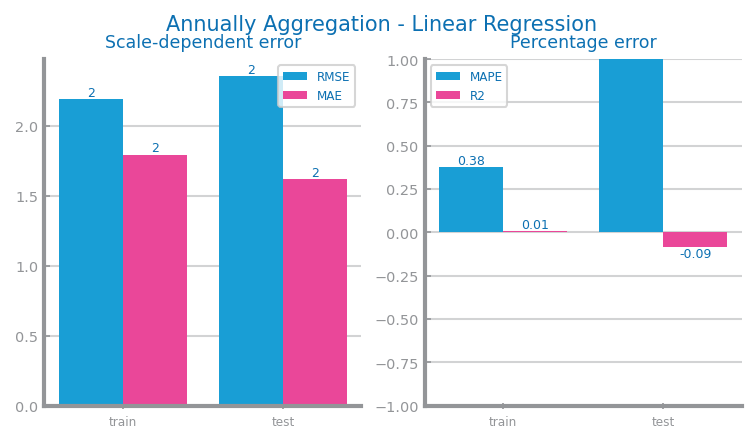

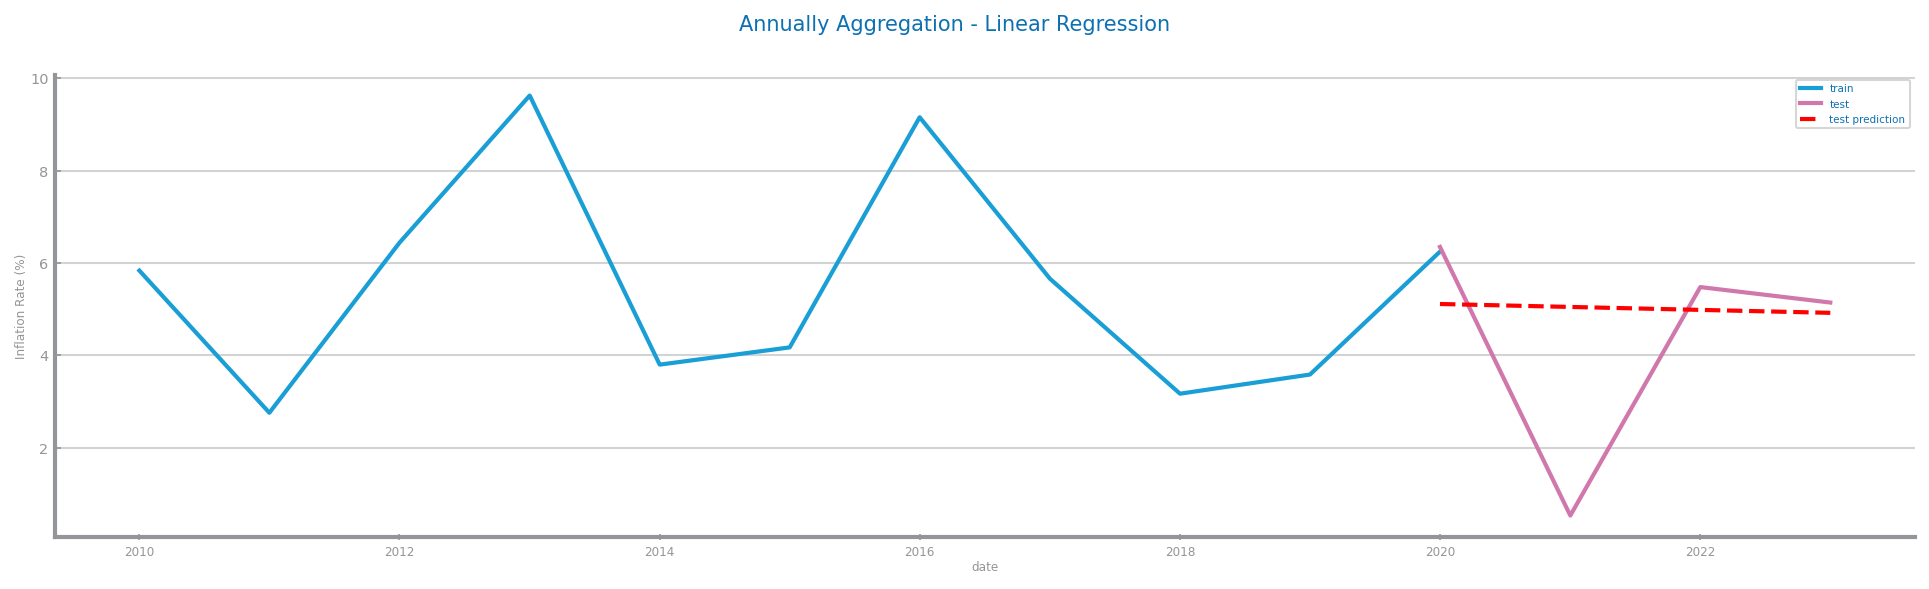

In [100]:
n_trn = len(series_A_train)
n_tst = len(series_A_test)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = series_A_train.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = series_A_test.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn_A: Series = Series(model.predict(trnX), index=series_A_train.index)
prd_tst_A: Series = Series(model.predict(tstX), index=series_A_test.index)

plot_forecasting_eval(
    series_A_train,
    series_A_test,
    prd_trn_A,
    prd_tst_A,
    title=f"Annually {file_tag} - Linear Regression"
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_linear_regression_A_eval.png")

plot_forecasting_series(
    series_A_train,
    series_A_test,
    prd_tst_A,
    title=f"Annually {file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"../../charts/lab5/preparation/aggregation/{file_tag}_linear_regression_A_forecast.png")

**Evaluation Notes:**

Note that we can only directly compare the Persistent Realist model with the Linear Regression model.

For all aggregation techniques, the Linear Regression model yields a lower MAE and RMSE than the Persisent Realist Model for the test set. Among the Linear Regression models, the Annual aggregation yields the lowest MAE for the test set (~1.6).

In [131]:
output_train_path = "../../data/prepared/aggregation/inflation_train_aggregation.csv"
output_train_multi_path = "../../data/prepared/aggregation/inflation_train_multi_aggregation.csv"
output_test_path  = "../../data/prepared/aggregation/inflation_test_aggregation.csv"
output_test_multi_path  = "../../data/prepared/aggregation/inflation_test_multi_aggregation.csv"


# Ensure they are DataFrames so the index is preserved cleanly
series_A_train.to_frame(name="Inflation Rate (%)").to_csv(output_train_path)
series_A_test.to_frame(name="Inflation Rate (%)").to_csv(output_test_path)

train_multi_A.to_csv(output_train_multi_path)
test_multi_A.to_csv(output_test_multi_path)



print("Saved annual aggregated train/test sets.")

Saved annual aggregated train/test sets.
